Here we will be computing 10 day VAR for S&P500 and NASDAQ100. Output count of breaches, a plot, list of breaches, and describe which index was more volatile during pandemic outbreak and subsequent recovery period

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

from data.fetch_data import fetch_and_save_data
from risk.var import historical_var, parametric_var, monte_carlo_var, calculate_daily_returns
from risk.utils import sharpe_ratio, calculate_log_returns, calculate_forward_log_returns, calculate_rolling_volatility, calculate_parametric_var, load_latest_price_data, detect_var_breaches, summarize_var_breaches
from risk.plotting import plot_var_breaches, plot_multiple_var_breaches
from config import TICKERS, START_DATE, END_DATE, PROCESSED_DATA_DIR, CONFIDENCE_LEVEL, MONTE_CARLO_SIMULATIONS

plt.style.use('ggplot')

In [2]:
# Load NASDAQ and S&P500 data 
nasdaq = load_latest_price_data(PROCESSED_DATA_DIR, 'nasdaq')
sp500 = load_latest_price_data(PROCESSED_DATA_DIR, 'sp500')

Loaded data from: /home/gusta/projects/VaR_exploration/data/processed/2025-03-30_nasdaq.csv
Loaded data from: /home/gusta/projects/VaR_exploration/data/processed/2025-03-30_sp500.csv


/home/gusta/projects/VaR_exploration/notebooks/../src/risk/utils.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(latest_filepath, index_col=0, parse_dates=True)
/home/gusta/projects/VaR_exploration/notebooks/../src/risk/utils.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(latest_filepath, index_col=0, parse_dates=True)


In [3]:
nasdaq_col = 'nasdaq_close'
sp500_col = 'sp500_close'

# Calculate daily log returns
nasdaq['ret_log'] = calculate_log_returns(nasdaq[nasdaq_col])
sp500['ret_log'] = calculate_log_returns(sp500[sp500_col])

# Calculate 10 day forward log returns
nasdaq['ret_10d'] = calculate_forward_log_returns(nasdaq[nasdaq_col], days_forward=10)
sp500['ret_10d'] = calculate_forward_log_returns(sp500[sp500_col], days_forward=10)

# Calculate rolling volatility using a 21-day window
nasdaq['std_21'] = calculate_rolling_volatility(nasdaq['ret_log'], window=21)
sp500['std_21'] = calculate_rolling_volatility(sp500['ret_log'], window=21)

# Calculate parametric VaR at 95% confidence level on a 10 day horizon
nasdaq['var_10d'] = calculate_parametric_var(nasdaq['std_21'], confidence_z=-2.33, horizon_days=10)
sp500['var_10d'] = calculate_parametric_var(sp500['std_21'], confidence_z=-2.33, horizon_days=10)

In [4]:
# Detect breaches
nasdaq = detect_var_breaches(nasdaq, return_col='ret_10d', var_col='var_10d')
sp500 = detect_var_breaches(sp500, return_col='ret_10d', var_col='var_10d')

# Summarize breaches
nasdaq_summary = summarize_var_breaches(nasdaq)
sp500_summary = summarize_var_breaches(sp500)

print(f"NASDAQ100 breaches count: {nasdaq_summary['count']}, Percentage breaches: {nasdaq_summary['percentage']}")
print(f"S&P500 breaches count: {sp500_summary['count']}, Percentage breaches: {sp500_summary['percentage']}")


NASDAQ100 breaches count: 58, Percentage breaches: 0.028
S&P500 breaches count: 74, Percentage breaches: 0.036


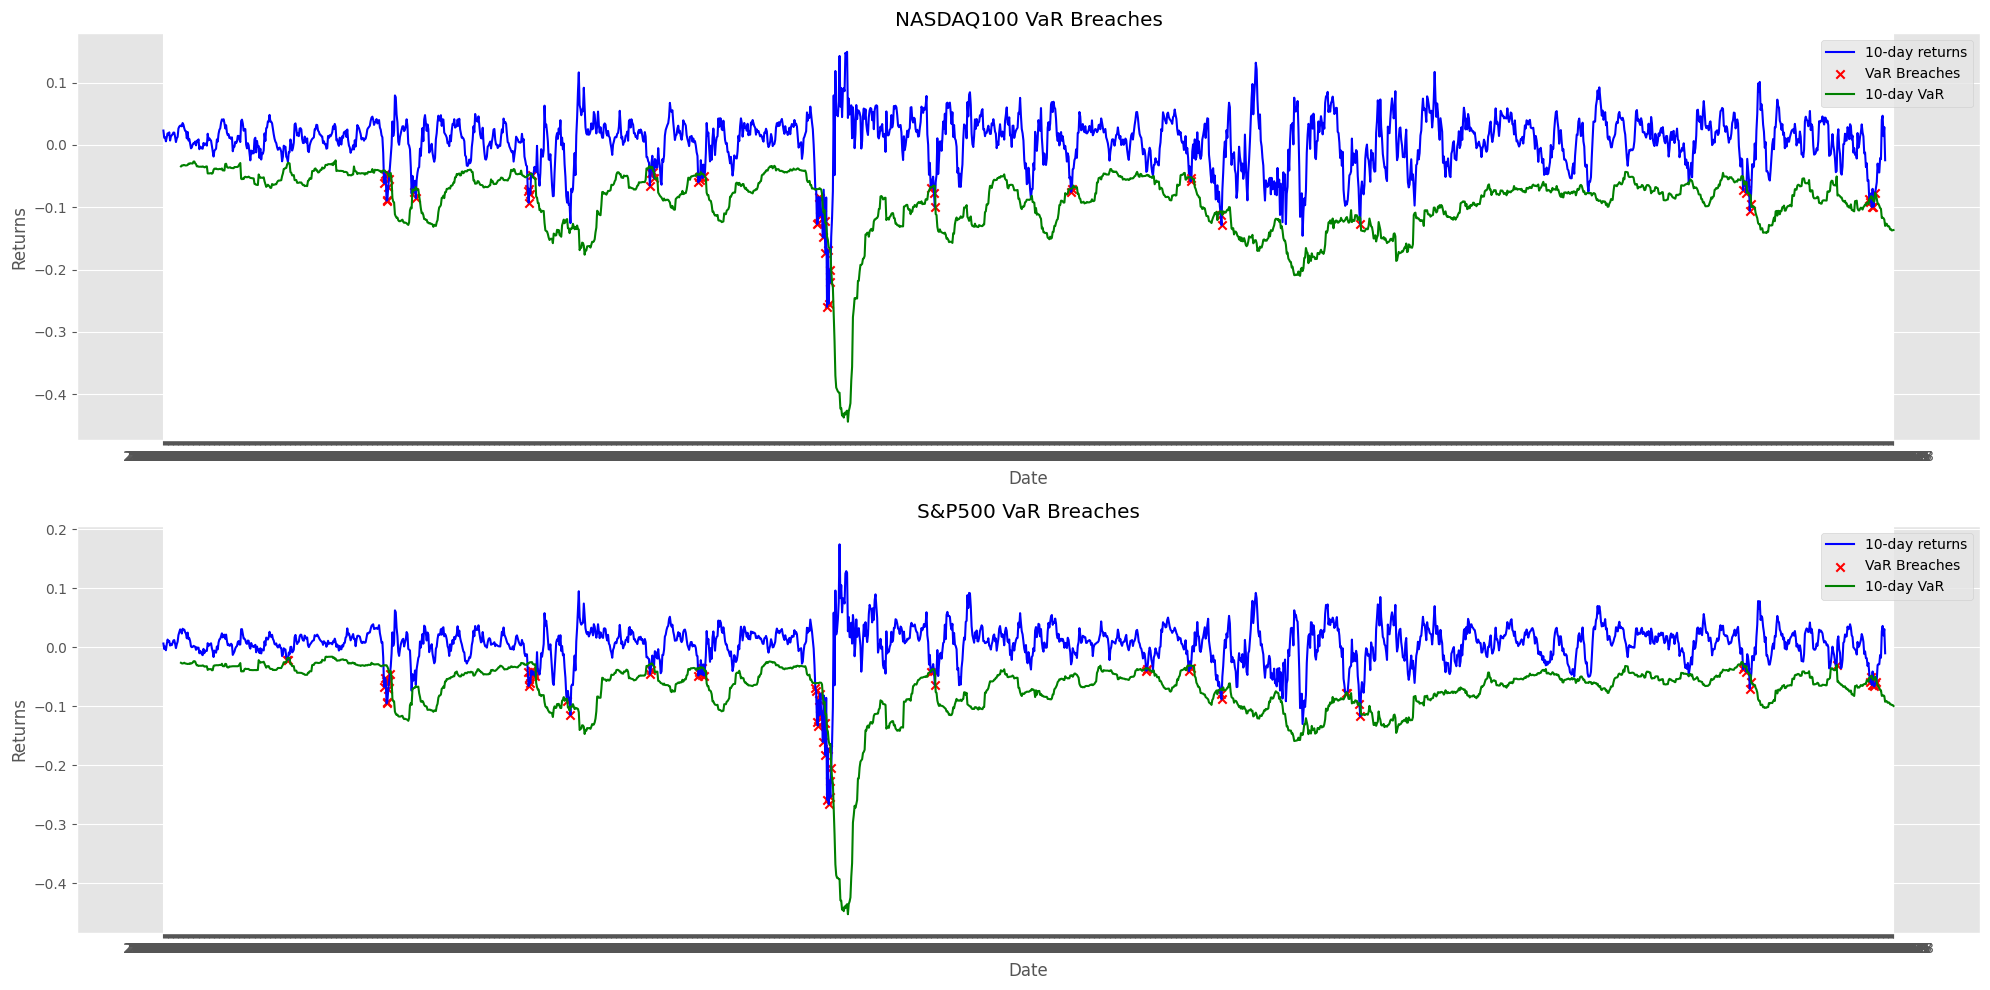

In [5]:
# Plot for one DataFrame:
# fig, ax = plt.subplots(figsize=(20, 5))
# plot_var_breaches(nasdaq, ax, title='NASDAQ100 VaR Breaches')

# ompare multiple assets:
data_list = [nasdaq, sp500]
titles_list = ["NASDAQ100 VaR Breaches", "S&P500 VaR Breaches"]

plot_multiple_var_breaches(
    data_list,
    titles=titles_list,
    breach_col='breach',
    return_col='ret_10d',
    var_col='var_10d'
)

In [6]:
# Filter breach rows for NASDAQ100
nasdaq_breach_table = nasdaq.loc[nasdaq['breach'],['nasdaq_close', 'ret_log', 'var_10d', 'ret_10d', 'breach']]
print("NASDAQ100 breaches:")
display(nasdaq_breach_table.head())

# Filter breach rows for S&P 500
sp500_breach_table = sp500.loc[sp500['breach'],['sp500_close', 'ret_log', 'var_10d', 'ret_10d', 'breach']]
print("S&P 500 breaches:")
display(sp500_breach_table.head())


NASDAQ100 breaches:


,nasdaq_close,ret_log,var_10d,ret_10d,breach
Date,,,,,
2018-01-22,7408.029785,0.009719,-0.041071,-0.061304,True
2018-01-23,7460.290039,0.007030,-0.041162,-0.047265,True
2018-01-24,7415.060059,-0.006081,-0.043681,-0.050205,True
2018-01-25,7411.160156,-0.000526,-0.043624,-0.089429,True
2018-01-26,7505.770020,0.012685,-0.044871,-0.087855,True


S&P 500 breaches:


,sp500_close,ret_log,var_10d,ret_10d,breach
Date,,,,,
2017-08-04,2476.830078,0.001887,-0.019588,-0.020921,True
2017-08-07,2480.909912,0.001646,-0.017641,-0.021405,True
2018-01-22,2832.969971,0.008034,-0.031004,-0.067166,True
2018-01-23,2839.129883,0.002172,-0.030470,-0.052048,True
2018-01-24,2837.540039,-0.000560,-0.030917,-0.056502,True


In [8]:
# Keep only rows where breach
nasdaq_breach_only = nasdaq_breach_table[nasdaq_breach_table['breach']]
sp500_breach_only  = sp500_breach_table[sp500_breach_table['breach']]

# COVID sell‑off period (Feb 1 – Mar 31 2020)
nasdaq_covid   = nasdaq_breach_only.loc['2020-02-01':'2020-03-31']
sp500_covid    = sp500_breach_only.loc['2020-02-01':'2020-03-31']

# COVID recovery period (Jan 1 2021 – Dec 31 2022)
nasdaq_recovery = nasdaq_breach_only.loc['2021-01-01':'2022-12-31']
sp500_recovery  = sp500_breach_only.loc['2021-01-01':'2022-12-31']

#  breach counts for each period
print(f"NASDAQ100 – COVID breaches: {len(nasdaq_covid)},  Recovery breaches: {len(nasdaq_recovery)}")
print(f"S&P 500   – COVID breaches: {len(sp500_covid)},  Recovery breaches: {len(sp500_recovery)}")


NASDAQ100 – COVID breaches: 15,  Recovery breaches: 7
S&P 500   – COVID breaches: 18,  Recovery breaches: 10


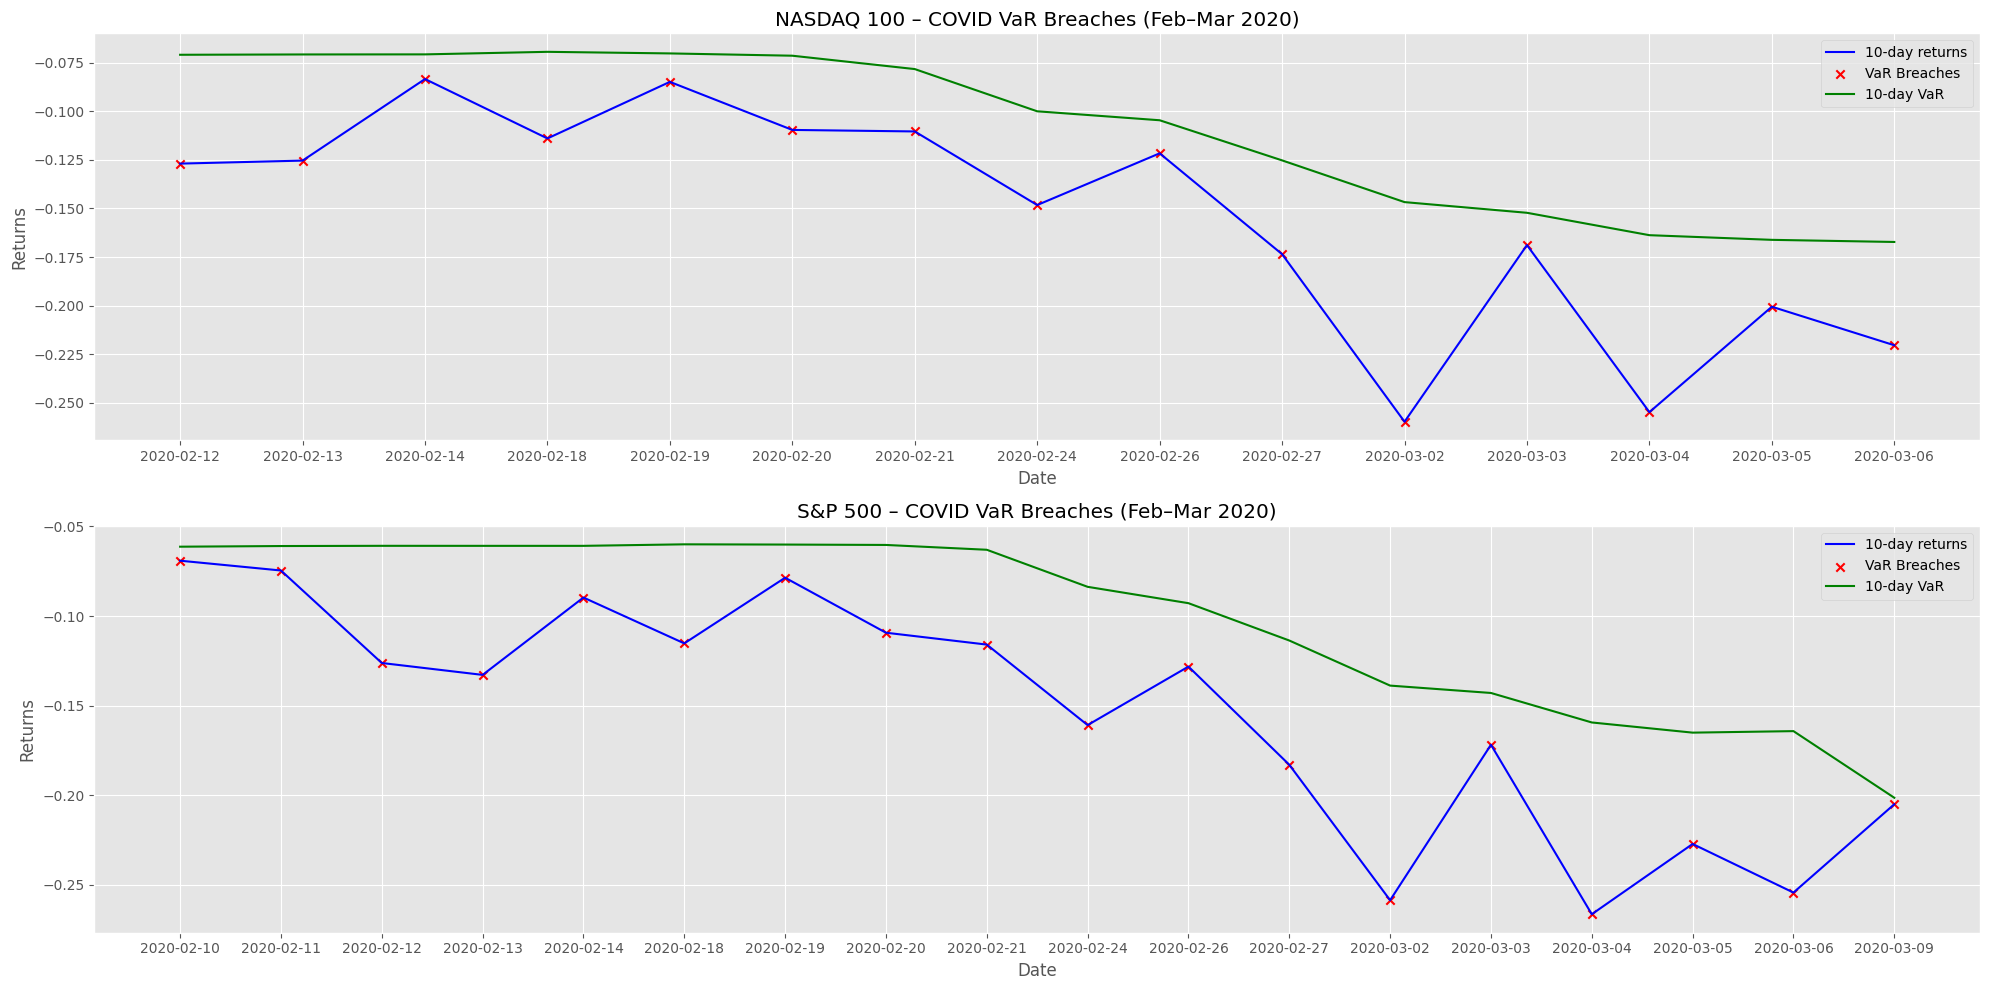

In [11]:
covid_data   = [nasdaq_covid, sp500_covid]
covid_titles = ["NASDAQ 100 – COVID VaR Breaches (Feb–Mar 2020)","S&P 500 – COVID VaR Breaches (Feb–Mar 2020)"]

plot_multiple_var_breaches(
    data_list=covid_data,
    titles=covid_titles,
    breach_col='breach',
    return_col='ret_10d',
    var_col='var_10d',
    figsize=(20, 5)
)

The S&P500 index appears more risky than the NASDAQ100 both during the covid period of february/march 2020 and the recovery period of 2021-2022. The S&P500 saw 50% more breaches in the 2 month span of the COVID outbreak, the S&P500 saw VaR breaches earlier in february than the NASDAQ, and also had twice as many breaches in early march.

Compared to the covid outbreak period of 2 months the recovery period defined as the 2 year period of 2021-2022 was calmer, with both indices having much fewer breaches in this 2 year period than they did during 2 months of covid. But still here the NASDAQ appears less risky only having 4 breaches, 2 per year compared to the S&P500 10 breaches or 5 per year.

There is not enough information to draw a conclusion or inference based on this data. But an initial hypothesis is that the NASDAQ index as a tech heavy index might not be as negativly affected by covid given peoples move to more digital lifes during lockdowns, technology stocks might not have been as hurt by the pandemic as other sectors since during lockdown people consumed technology more and more. It would from that perspective make sense for a tech heavy index such as NASDAQ to be less risky in such an event than a more general economy exposed index such as S&P500.

#### Now let's do the same analysis but using EWMA instead of 10 day VAR

In [ ]:
# Initialize the variance
nq100['EWMA'] = nq100['ret_log'].var()
sp500['EWMA'] = sp500['ret_log'].var()

# Calculate EWMA = lamda*previous day EWMA + (1-lambda) * (previous day return)^2
for i in range(1, len(nq100)):
        nq100.loc[nq100.index[i], 'EWMA'] = (0.72 * nq100['EWMA'].iloc[i-1] +
                                            (1 - 0.72) * nq100['ret_log'].iloc[i] ** 2)
for i in range(1, len(sp500)):
        sp500.loc[sp500.index[i], 'EWMA'] = (0.72 * sp500['EWMA'].iloc[i-1] + 
                                             (1 - 0.72) * sp500['ret_log'].iloc[i] ** 2)

In [ ]:
# Calculate 99% var, the left tail cutoff is approx z = -2.33
nq100['ewma_10d'] = -2.33 * (10 * nq100['EWMA']) ** 0.5
sp500['ewma_10d'] = -2.33 * (10 * sp500['EWMA']) ** 0.5

# Check for breaches
nq100['breach_ewma'] = (nq100['ret_10d'] < nq100['ewma_10d']) & (nq100['ret_10d'] < 0)
sp500['breach_ewma'] = (sp500['ret_10d'] < sp500['ewma_10d']) & (sp500['ret_10d'] < 0)

In [ ]:
# Count and percentage VAR breaches per index
print('NASDAQ100 EWMA breaches count:', 
      nq100['breach_ewma'][nq100['breach_ewma'] == True].count(),
      'Percentage breaches:', 
      round(nq100['breach_ewma'].mean(),3))
print('S&P500 EWMA breaches count:', 
      sp500['breach_ewma'][sp500['breach_ewma'] == True].count(),
      'Percentage breaches:', 
      round(sp500['breach_ewma'].mean(),3))

In [ ]:
# Create two subplots so we can compare the S&P500 to the NASDAQ100 VAR breaches
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Use our previously defined plotting function  adjusting it to use EWMA breach column
plot_var_breaches(nq100, 'NASDAQ100 EWMA VaR Breaches', 'breach_ewma', ax1)
plot_var_breaches(sp500, 'S&P 500 EWMA VaR Breaches','breach_ewma', ax2)

# Display the plot
plt.show()

In [ ]:
# NASDAQ100 list of VAR breaches
nq100_breach_table = nq100[['Closing Price', 'ret_log', 'ewma_10d', 'ret_10d', 'breach_ewma']]
print('NASDAQ100', nq100_breach_table[nq100_breach_table['breach_ewma']==True].head())


#S&P500 list of VAR breaches
sp500_breach_table = sp500[['Closing Price', 'ret_log', 'ewma_10d', 'ret_10d', 'breach_ewma']]
print('S&P500', sp500_breach_table[sp500_breach_table['breach_ewma']==True].head())

In [ ]:
# Filter for only breaches
nq100_breach_table = nq100_breach_table[nq100_breach_table['breach_ewma']==True]
sp500_breach_table = sp500_breach_table[sp500_breach_table['breach_ewma']==True]

# Filter for covid period
nq100_covid_breaches = nq100_breach_table.loc['2020-02-01':'2020-03-31']
sp500_covid_breaches = sp500_breach_table.loc['2020-02-01':'2020-03-31']

# Filter for recovery Period
nq100_recovery_breaches = nq100_breach_table.loc['2021-01-01':'2022-12-31']
sp500_recovery_breaches = sp500_breach_table.loc['2021-01-01':'2022-12-31']

# Print number of breaches during each period
print('NASDAQ100 covid EWMA breaches:', 
      len(nq100_covid_breaches), 
      'Recovery EWMA breaches:', 
      len(nq100_recovery_breaches))
print('S&P500 covid EWMA breaches:', 
      len(sp500_covid_breaches), 
      'Recovery EWMA breaches:', 
      len(sp500_recovery_breaches))

 λ impacts the smoothness of predicted EWMA volatility: The higher the λ the more weight is being given to the most recent variance, and less to the most recent return. Volatility tends to cluster together while returns follow a random walk, therefore giving more weight (higher λ) to the most recent variance results in a smoother predicted volatility.